# Cleaning and EDA

---

## Initial Steps - Imports, First Look, and Functions

In [505]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [506]:
raw_housing = pd.read_csv('../datasets/train.csv')

In [507]:
raw_housing.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [508]:
def groupby_saleprice(feature):
    '''
    Quick check of the mean sale prices across the different categorical values in a given feature
    '''
    return raw_housing.groupby(feature).mean()[['SalePrice']]


# maybe a function that converts overall quality and condition to numerical values and combines them (maybe multiplication)

# quality/cond conversion dictionary
def qual_to_num(feature):
    qual_conversion = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, np.nan: 0}
    
    house[feature] = house[feature].apply(lambda x: qual_conversion[x])
    
    
def vif_df(df):
    corr_features = df.columns
    vif_values = [variance_inflation_factor(df.values, i) for i in range(len(corr_features))]
    
    vif = pd.DataFrame(vif_values,
                   index = corr_features,
                   columns = ['vif']).sort_values(by = 'vif', ascending = False)
    
    return vif



In [509]:
# potential correlation
# land contour and land slope
# Year Built and Year Remod/Add

# medium interest in including
# land contour, Bldg Type, Mas Vnr Type

# not crazy about including
# land slope, Condition 1, Year Built, Bsmt Qual
# Wood Deck SF, Open Porch SF, Kitchen Qual
# Fireplaces, Fireplace Qu

# to combine
# Overall Qual and Overall Cond
# Exter Qual and Exter Cond
# Bsmt Qual and Bsmt Cond #
# Full Bath and Half Bath
# Fireplaces and Fireplace Qu
# 1*BsmtFin SF 1 + 0.5*Bsmt Unf SF

features = ['MS Zoning', 'Lot Area', 'Land Contour', 'Land Slope', 'Neighborhood', 'Condition 1',
            'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
           'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
           'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Kitchen Qual', 'Gr Liv Area', 'Bedroom AbvGr',
           'Full Bath', 'Half Bath', 'Fireplaces', 'Fireplace Qu', 'BsmtFin SF 1', 'Bsmt Unf SF', 'SalePrice']

In [510]:
house = raw_housing[features].copy()
house.head()

,MS Zoning,Lot Area,Land Contour,Land Slope,Neighborhood,Condition 1,Bldg Type,House Style,Overall Qual,Overall Cond,...,Kitchen Qual,Gr Liv Area,Bedroom AbvGr,Full Bath,Half Bath,Fireplaces,Fireplace Qu,BsmtFin SF 1,Bsmt Unf SF,SalePrice
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,6,8,...,Gd,1479,3,2,1,0,NaN,533.0,192.0,130500
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,7,5,...,Gd,2122,4,2,1,1,TA,637.0,276.0,220000
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,5,7,...,Gd,1057,3,1,0,0,NaN,731.0,326.0,109000
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,5,5,...,TA,1444,3,2,1,0,NaN,0.0,384.0,174000
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,6,8,...,TA,1445,3,2,0,0,NaN,0.0,676.0,138500


In [511]:
house.columns = [col.lower().replace(' ','_').replace('/','_') for col in house.columns]

In [512]:
house.head()

,ms_zoning,lot_area,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,overall_qual,overall_cond,...,kitchen_qual,gr_liv_area,bedroom_abvgr,full_bath,half_bath,fireplaces,fireplace_qu,bsmtfin_sf_1,bsmt_unf_sf,saleprice
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,6,8,...,Gd,1479,3,2,1,0,NaN,533.0,192.0,130500
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,7,5,...,Gd,2122,4,2,1,1,TA,637.0,276.0,220000
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,5,7,...,Gd,1057,3,1,0,0,NaN,731.0,326.0,109000
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,5,5,...,TA,1444,3,2,1,0,NaN,0.0,384.0,174000
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,6,8,...,TA,1445,3,2,0,0,NaN,0.0,676.0,138500


---

## Dealing with Missing Values and Combining Columns

In [513]:
house.isnull().sum()

ms_zoning            0
lot_area             0
land_contour         0
land_slope           0
neighborhood         0
condition_1          0
bldg_type            0
house_style          0
overall_qual         0
overall_cond         0
year_built           0
year_remod_add       0
mas_vnr_type        22
exter_qual           0
exter_cond           0
bsmt_qual           55
bsmt_cond           55
garage_area          1
wood_deck_sf         0
open_porch_sf        0
kitchen_qual         0
gr_liv_area          0
bedroom_abvgr        0
full_bath            0
half_bath            0
fireplaces           0
fireplace_qu      1000
bsmtfin_sf_1         1
bsmt_unf_sf          1
saleprice            0
dtype: int64

There is one row missing all the basement data. It may be fair to assume that the home is missing a basement and these values would all be zero.

In [514]:
null_basement_info = house[house['bsmtfin_sf_1'].isna()]
null_basement_info[['bsmt_qual', 'bsmt_cond', 'garage_area', 'bsmtfin_sf_1', 'bsmt_unf_sf']]

,bsmt_qual,bsmt_cond,garage_area,bsmtfin_sf_1,bsmt_unf_sf
1327,NaN,NaN,280.0,NaN,NaN


In [515]:
# turn missing basement square feet info into zeros
# basement quality and condition will be dealt with later
house.loc[house['bsmtfin_sf_1'].isna(), ['bsmtfin_sf_1', 'bsmt_unf_sf']] = 0

We only have one garage related column so it is more challenging to infer about the row with a missing `garage_area` value. It is likely fine to convert this singe row's `garage_area` value to zero also.

In [516]:
house.loc[house['garage_area'].isna(), 'garage_area'] = 0

Missing values in the basement columns appear to be homes without basements. We see the missing 55 entries in the same rows for `bsmt_qual` and `bsmt_cond`.

In [517]:
house.loc[house['bsmt_qual'].isnull(), 'bsmt_cond'].value_counts(dropna = False)

NaN    55
Name: bsmt_cond, dtype: int64

In [518]:
# converts descriptive rating to numerical
qual_to_num('bsmt_qual')
qual_to_num('bsmt_cond')

# combines basment quality and condition ratings via multiplication
house['bsmt_qual_cond'] = house['bsmt_qual'] * house['bsmt_cond']
house.drop(columns = ['bsmt_qual', 'bsmt_cond'], inplace = True)

We see the same issue arise with `fireplaces` and `fireplace_qu`. The homes with zero fireplaces are fittingly missing descriptions for the quality of their fireplace.

In [519]:
house.loc[house['fireplaces'] == 0, 'fireplace_qu'].value_counts(dropna = False)

NaN    1000
Name: fireplace_qu, dtype: int64

In [520]:
# converts descriptive rating to numerical
qual_to_num('fireplace_qu')

# combines fireplace count and quality rating via multiplication
house['fireplaces_weighted'] = house['fireplaces'] * house['fireplace_qu']
house.drop(columns = ['fireplaces', 'fireplace_qu'], inplace = True)

The only remaining column with missing entires is `mas_vnr_typ`. This is not something we can reasonably adjust, so we will leave these missing values in until they give us a reason to drop them or the column.

In [521]:
house.isnull().sum()

ms_zoning               0
lot_area                0
land_contour            0
land_slope              0
neighborhood            0
condition_1             0
bldg_type               0
house_style             0
overall_qual            0
overall_cond            0
year_built              0
year_remod_add          0
mas_vnr_type           22
exter_qual              0
exter_cond              0
garage_area             0
wood_deck_sf            0
open_porch_sf           0
kitchen_qual            0
gr_liv_area             0
bedroom_abvgr           0
full_bath               0
half_bath               0
bsmtfin_sf_1            0
bsmt_unf_sf             0
saleprice               0
bsmt_qual_cond          0
fireplaces_weighted     0
dtype: int64

In [522]:
house['mas_vnr_type'].value_counts(dropna = False)

None       1218
BrkFace     630
Stone       168
NaN          22
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [523]:
# To edit
# features = ['MS Zoning', 'Lot Area', 'Land Contour', 'Land Slope', 'Neighborhood', 'Condition 1',
#            'Bldg Type', 'House Style', 'Year Built', 'Year Remod/Add',
#           'Mas Vnr Type', 'Bsmt Qual', 'Bsmt Cond', 'Total Bsmt SF',
#           'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Kitchen Qual', 'Gr Liv Area', 'Bedroom AbvGr']

In [524]:
# adds square feet (SF) measurements with weights:
# 1*(Finished SF) + 0.5(Unfinished SF)
house['bsmt_weighted_sf'] = house['bsmtfin_sf_1'] + 0.5*house['bsmt_unf_sf']
house.drop(columns = ['bsmtfin_sf_1', 'bsmt_unf_sf'], inplace = True)

In [525]:
# combines overall quality and condition into one column via multiplication
house['qual_cond'] = house['overall_qual'] * house['overall_cond']
house.drop(columns = ['overall_qual', 'overall_cond'], inplace = True)

In [526]:
# converts descriptive rating to numerical
qual_to_num('exter_qual')
qual_to_num('exter_cond')

# combines exterior quality and condition into one column via multiplication
house['exter_qual_cond'] = house['exter_qual'] * house['exter_cond']
house.drop(columns = ['exter_qual', 'exter_cond'], inplace = True)

In [527]:
# combines full bath and half bath into one column
house['bath'] = house['full_bath'] + 0.5*house['half_bath']
house.drop(columns = ['full_bath', 'half_bath'], inplace = True)

In [528]:
# convert descriptive rating to numerical
qual_to_num('kitchen_qual')

In [244]:
# consider squaring kitchen qual to match how other ratings are qual * cond

---

## Removing Outliers and Exploratory Data Analysis

In [530]:
house.describe()

,lot_area,year_built,year_remod_add,garage_area,wood_deck_sf,open_porch_sf,kitchen_qual,gr_liv_area,bedroom_abvgr,saleprice,bsmt_qual_cond,fireplaces_weighted,bsmt_weighted_sf,qual_cond,exter_qual_cond,bath
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,10065.208191,1971.708922,1984.190151,473.440761,93.833740,47.556802,3.517309,1499.330083,2.843491,181469.701609,10.549000,2.033642,725.810580,33.866407,10.518284,1.762799
std,6742.488909,30.177889,21.036250,216.135102,128.549416,66.747241,0.665577,500.447829,0.826618,79258.659352,3.061151,2.283203,406.466601,9.255859,2.195124,0.637775
min,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,2.000000,334.000000,0.000000,12789.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
25%,7500.000000,1953.500000,1964.500000,319.000000,0.000000,0.000000,3.000000,1129.000000,2.000000,129825.000000,9.000000,0.000000,440.250000,30.000000,9.000000,1.000000
50%,9430.000000,1974.000000,1993.000000,480.000000,0.000000,27.000000,3.000000,1444.000000,3.000000,162500.000000,12.000000,1.000000,674.500000,35.000000,9.000000,2.000000
75%,11513.500000,2001.000000,2004.000000,576.000000,168.000000,70.000000,4.000000,1728.500000,3.000000,214000.000000,12.000000,4.000000,916.750000,40.000000,12.000000,2.500000
max,159000.000000,2010.000000,2010.000000,1418.000000,1424.000000,547.000000,5.000000,5642.000000,8.000000,611657.000000,20.000000,12.000000,5877.000000,90.000000,25.000000,5.000000


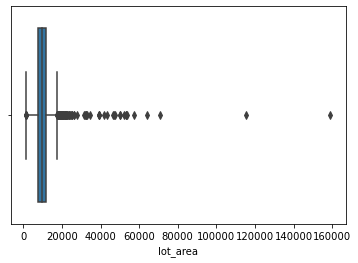

In [534]:
sns.boxplot(x = house['lot_area']);

In [ ]:
house['lot_area'] 

In [535]:
log_lot_area = np.log(house['lot_area'])

<AxesSubplot:xlabel='lot_area'>

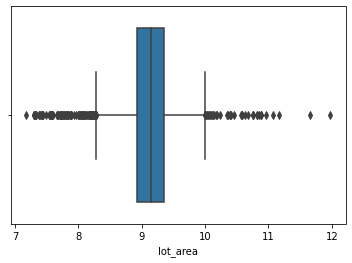

In [537]:
sns.boxplot(x = log_lot_area)

In [540]:
perc_25 = house['lot_area'].quantile(0.25)

In [541]:
perc_75 = house['lot_area'].quantile(0.75)

In [542]:
perc_75

11513.5

In [543]:
large_lot = house[house['lot_area'] > perc_75]

In [544]:
large_lot

,ms_zoning,lot_area,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,year_built,year_remod_add,...,kitchen_qual,gr_liv_area,bedroom_abvgr,saleprice,bsmt_qual_cond,fireplaces_weighted,bsmt_weighted_sf,qual_cond,exter_qual_cond,bath
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,1976,2005,...,4,1479,3,130500,9,0,629.0,48,12,2.5
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,1900,1993,...,3,1445,3,138500,8,0,338.0,48,9,2.0
5,RL,16492,Lvl,Gtl,NAmes,PosA,1Fam,1Story,1966,2002,...,4,1888,2,190000,9,4,525.5,36,12,2.5
7,RL,12160,Lvl,Gtl,NAmes,Norm,1Fam,1Story,1959,1959,...,3,1188,3,142000,9,0,1094.0,25,9,1.0
8,RL,15783,Lvl,Gtl,OldTown,Artery,1Fam,1Story,1952,1952,...,3,924,2,112500,9,0,608.0,25,9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,RL,13350,Lvl,Gtl,Sawyer,Norm,1Fam,1Story,1974,1974,...,3,894,3,142500,9,2,813.0,25,9,1.0
2040,RL,15593,Lvl,Gtl,ClearCr,Norm,1Fam,1.5Fin,1953,1953,...,3,2287,3,225000,9,3,953.5,28,12,2.0
2041,RL,13688,Lvl,Gtl,NridgHt,Norm,1Fam,2Story,2003,2004,...,5,2668,3,412500,15,8,1294.0,45,12,2.5
2045,RL,12444,Lvl,Gtl,NridgHt,Norm,1Fam,1Story,2008,2008,...,5,1932,2,394617,15,4,1634.0,40,15,2.0


In [554]:
large_lot['lot_area'].value_counts(bins = 25).sort_index()

(11367.514, 17414.4]    424
(17414.4, 23313.8]       55
(23313.8, 29213.2]        9
(29213.2, 35112.6]        6
(35112.6, 41012.0]        3
(41012.0, 46911.4]        3
(46911.4, 52810.8]        5
(52810.8, 58710.2]        4
(58710.2, 64609.6]        1
(64609.6, 70509.0]        0
(70509.0, 76408.4]        1
(76408.4, 82307.8]        0
(82307.8, 88207.2]        0
(88207.2, 94106.6]        0
(94106.6, 100006.0]       0
(100006.0, 105905.4]      0
(105905.4, 111804.8]      0
(111804.8, 117704.2]      1
(117704.2, 123603.6]      0
(123603.6, 129503.0]      0
(129503.0, 135402.4]      0
(135402.4, 141301.8]      0
(141301.8, 147201.2]      0
(147201.2, 153100.6]      0
(153100.6, 159000.0]      1
Name: lot_area, dtype: int64

In [555]:
house.shape

(2051, 24)

In [556]:
513-479

34

In [559]:
34/2051

0.01657727937591419

In [560]:
424/513

0.8265107212475633

We see that 75% of the homes in Ames contain less than 11,513 square feet of lot area. Within the upper quartile, 82% of the remaining homes still have less 17,414 square feet of area. We then see a significant drop off in number of homes containing more than 23,313.8 square feet of lot area. Let us trim off these outliers that make up less than 2% of the data.

In [561]:
house = house[house['lot_area'] <= 23313.8]

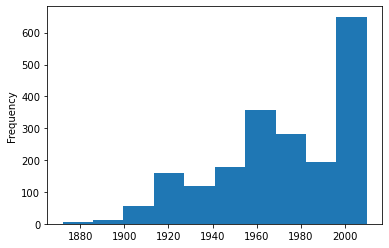

In [565]:
house['year_built'].plot.hist(bins = 10);

In [566]:
house['year_built'].value_counts(bins = 10).sort_index()

(1871.861, 1885.8]      6
(1885.8, 1899.6]       12
(1899.6, 1913.4]       56
(1913.4, 1927.2]      161
(1927.2, 1941.0]      138
(1941.0, 1954.8]      159
(1954.8, 1968.6]      358
(1968.6, 1982.4]      282
(1982.4, 1996.2]      195
(1996.2, 2010.0]      650
Name: year_built, dtype: int64

In [569]:
house.loc[house['year_built'] < 1900, ['year_built', 'saleprice']].sort_values(by = 'year_built')

,year_built,saleprice
951,1872,122000
136,1875,94000
1134,1879,185000
1939,1880,295000
784,1880,117500
394,1885,122500
1318,1890,159500
1204,1890,95000
918,1890,124900
501,1890,78500


In [571]:
house.loc[house['year_built'] < 1900, 'saleprice'].mean()

160591.0

In [570]:
house['saleprice'].mean()

180535.66336142787

It does not seem necessary to drop homes built especially long ago. These homes to not appear to have extraordinary sale prices.

In [572]:
house.describe()

,lot_area,year_built,year_remod_add,garage_area,wood_deck_sf,open_porch_sf,kitchen_qual,gr_liv_area,bedroom_abvgr,saleprice,bsmt_qual_cond,fireplaces_weighted,bsmt_weighted_sf,qual_cond,exter_qual_cond,bath
count,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,9469.236986,1971.818542,1984.235002,469.894398,92.634110,46.996529,3.515617,1488.120476,2.840357,180535.663361,10.553793,1.991076,717.810858,33.877045,10.515121,1.760040
std,3590.363046,30.241305,21.023331,213.398400,126.260462,65.392720,0.663593,480.490681,0.822126,78316.495002,3.036028,2.244022,377.033187,9.208603,2.191681,0.634593
min,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,2.000000,334.000000,0.000000,12789.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
25%,7476.000000,1953.000000,1965.000000,313.000000,0.000000,0.000000,3.000000,1125.000000,2.000000,129500.000000,9.000000,0.000000,440.000000,30.000000,9.000000,1.000000
50%,9350.000000,1975.000000,1993.000000,478.000000,0.000000,26.000000,3.000000,1440.000000,3.000000,161500.000000,12.000000,1.000000,672.000000,35.000000,9.000000,2.000000
75%,11361.000000,2001.000000,2004.000000,576.000000,168.000000,70.000000,4.000000,1724.000000,3.000000,213000.000000,12.000000,4.000000,911.000000,40.000000,12.000000,2.000000
max,22950.000000,2010.000000,2010.000000,1348.000000,1424.000000,547.000000,5.000000,3672.000000,8.000000,611657.000000,20.000000,12.000000,2319.000000,90.000000,25.000000,5.000000


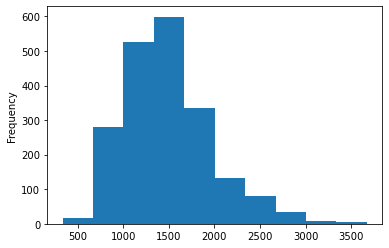

In [574]:
house['gr_liv_area'].plot.hist();

<AxesSubplot:xlabel='gr_liv_area'>

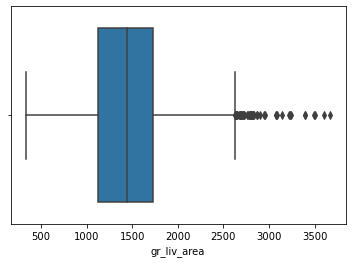

In [575]:
sns.boxplot(x = house['gr_liv_area'])

In [579]:
house['gr_liv_area'].value_counts(bins = 10).sort_index()

(330.661, 667.8]     17
(667.8, 1001.6]     281
(1001.6, 1335.4]    525
(1335.4, 1669.2]    599
(1669.2, 2003.0]    334
(2003.0, 2336.8]    132
(2336.8, 2670.6]     81
(2670.6, 3004.4]     35
(3004.4, 3338.2]      7
(3338.2, 3672.0]      6
Name: gr_liv_area, dtype: int64

--- 

## Determining Which Numeric Features to Use

Let us begin by determining which numeric values are most relevant to `saleprice` and are not very correlated to one another.

In [245]:
house

,ms_zoning,lot_area,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,year_built,year_remod_add,...,kitchen_qual,gr_liv_area,bedroom_abvgr,saleprice,bsmt_qual_cond,fireplaces_weighted,bsmt_weighted_sf,qual_cond,exter_qual_cond,bath
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,1976,2005,...,4,1479,3,130500,9,0,629.0,48,12,2.5
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,1996,1997,...,4,2122,4,220000,12,3,775.0,35,12,2.5
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,1953,2007,...,4,1057,3,109000,9,0,894.0,35,12,1.0
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,2006,2007,...,3,1444,3,174000,12,0,192.0,25,9,2.5
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,1900,1993,...,3,1445,3,138500,8,0,338.0,48,9,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,RL,11449,HLS,Gtl,Timber,Norm,1Fam,1Story,2007,2007,...,4,1728,3,298751,12,4,1447.5,40,12,2.0
2047,RL,12342,Lvl,Gtl,Edwards,Norm,1Fam,1Story,1940,1950,...,3,861,1,82500,9,0,561.5,20,9,1.0
2048,RL,7558,Bnk,Gtl,Crawfor,Norm,1Fam,1.5Fin,1928,1950,...,3,1913,3,177000,9,3,448.0,36,9,1.5
2049,RL,10400,Lvl,Gtl,NAmes,Norm,1Fam,1Story,1956,1956,...,3,1200,3,144000,9,8,302.5,20,9,1.0


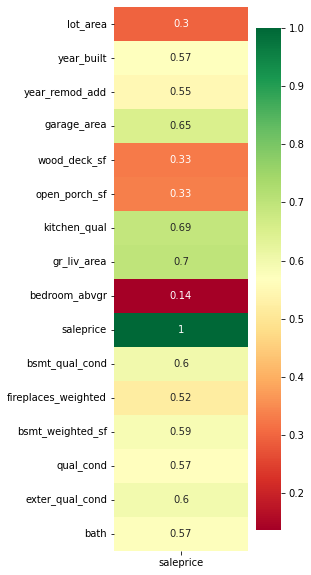

In [246]:
plt.figure(figsize = (3,10))
sns.heatmap(house.corr()[['saleprice']], cmap = 'RdYlGn', annot = True);

Out of the numeric features we have selected/created, three stand out as correlated to `saleprice`: `gr_liv_area`, `kitchen_qual`, and `garage_area`. It would be nice if we could use all of these features in our model, unfortunately, their variance inflation factors are quite large.

In [247]:
vif_df(house[['gr_liv_area', 'kitchen_qual', 'garage_area']])

,vif
kitchen_qual,14.528355
gr_liv_area,13.761834
garage_area,8.489178


In [248]:
vif_df(house[['gr_liv_area', 'garage_area']])

,vif
gr_liv_area,7.136874
garage_area,7.136874


This suggests we should only use `gr_liv_area` out of `gr_liv_area`, `kitchen_qual`, and `garage_area`.

In [250]:
vif_df(house[['gr_liv_area', 'lot_area']])

,vif
gr_liv_area,3.513992
lot_area,3.513992


After trial and error, `gr_liv_area` only obtains a VIF score below 5 with `lot_area`, `bsmt_weighted_sf`, `open_porch_sf`, or `wood_deck_sf`. The first two seem the most relevant and `open_porch_sf` makes the VIF too large to reasonably include categorical variables.

Of the numeric columns, let us only consider using `gr_liv_area` and `lot_area` in our linear regression model.

In [251]:
numeric_features = ['gr_liv_area', 'lot_area']

In [ ]:
### revise below

In [160]:
# seems early to define x

# learned about method from https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
X = house.select_dtypes(include = ['int64', 'float64']).copy()
y = house['saleprice']

In [161]:
X.drop(columns = ['kitchen_qual', 'garage_area', 'saleprice'], inplace = True)

In [162]:
#gr_liv_area,
# lot_area, bsmt_weighted_sf
vif_df(X[['gr_liv_area', 'lot_area']])

,vif
gr_liv_area,3.513992
lot_area,3.513992


---

## Determining Which Categorical Features to Use

In [254]:
categoric = house.select_dtypes(include = ['object'])

In [255]:
categoric

,ms_zoning,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,mas_vnr_type
0,RL,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,BrkFace
1,RL,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,BrkFace
2,RL,Lvl,Gtl,NAmes,Norm,1Fam,1Story,None
3,RL,Lvl,Gtl,Timber,Norm,1Fam,2Story,None
4,RL,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,None
...,...,...,...,...,...,...,...,...
2046,RL,HLS,Gtl,Timber,Norm,1Fam,1Story,None
2047,RL,Lvl,Gtl,Edwards,Norm,1Fam,1Story,None
2048,RL,Bnk,Gtl,Crawfor,Norm,1Fam,1.5Fin,None
2049,RL,Lvl,Gtl,NAmes,Norm,1Fam,1Story,None


In [256]:
for col in categoric.columns:
    print(categoric[col].value_counts(dropna = False))

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64
Lvl    1843
HLS      85
Bnk      80
Low      43
Name: land_contour, dtype: int64
Gtl    1953
Mod      88
Sev      10
Name: land_slope, dtype: int64
NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker     17
NPkVill     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64
Norm      1767
Feedr      109
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: condition_1, dtype: int64
1Fam      1700
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: bldg_type

We saw earlier that despite wanting to include many numeric columns, most of them were correlated to one another and we could really only use two. In the same spirit avoiding multicollinearity among the nurmic variables, let us be picky about which categorical features we decide to use in our model.

`neighborhood` immediately stands out as an indicator of property value. Almost all the other categorical variables have more than 1500 appearances of a single category (out of 2051). This leads me to believe these features will not do a great job at separating out the values of the different homes. Besides `neighborhood`, only `house_style` and `mas_vnr_type` have more spread out values. Since `mas_vnr_type` does not stand out to me as influencing the value of a home that much, I will only use `neighborhood` and `house_style` for the categorical features in our model.

\* In a future model, I will include `mas_vnr_type` to see if my intuition was correct.\*

In [257]:
categ_features = ['neighborhood', 'house_style']

In [ ]:
# possibly keeping
# neighborhood, house_style - possibly correlated with gr_liv_area

# mid level interest
# mas_vnr_type

# likely not keeping
# ms_zoning, land_contour, land_slope,

---

## Making Sure Dummy Columns Agree Between Train and Test

In [258]:
house_predictors = house[numeric_features + categ_features]

In [430]:
raw_house_test = pd.read_csv('../datasets/test.csv')

In [273]:
# index [:-1] to exclude saleprice from features
# since it doesn't appear in test data
house_test = house_test[features[:-1]]

house_test.isnull().sum()

MS Zoning           0
Lot Area            0
Land Contour        0
Land Slope          0
Neighborhood        0
Condition 1         0
Bldg Type           0
House Style         0
Overall Qual        0
Overall Cond        0
Year Built          0
Year Remod/Add      0
Mas Vnr Type        1
Exter Qual          0
Exter Cond          0
Bsmt Qual          25
Bsmt Cond          25
Garage Area         0
Wood Deck SF        0
Open Porch SF       0
Kitchen Qual        0
Gr Liv Area         0
Bedroom AbvGr       0
Full Bath           0
Half Bath           0
Fireplaces          0
Fireplace Qu      422
BsmtFin SF 1        0
Bsmt Unf SF         0
dtype: int64

In [274]:
house_test.columns = [col.lower().replace(' ','_').replace('/','_') for col in house_test.columns]

In [276]:
house_test = house_test[numeric_features + categ_features]

In [277]:
# Train and test may have different appearance of categorical values
# dummy columns might not agree and will interfere with running model
# on test data

# dummify
train_with_dummies = pd.get_dummies(house_predictors, columns = categ_features, drop_first = True)
test_with_dummies = pd.get_dummies(house_test, columns = categ_features, drop_first = True)

In [278]:
# check column counts pre changes
print(train_with_dummies.shape)
print(test_with_dummies.shape)

(2051, 36)
(878, 34)


In [279]:
# save dummy column names from both train and test to a set
both_columns_set = set(train_with_dummies.columns).union(set(test_with_dummies.columns))

# for any column names not in set add column with 0s
for col in both_columns_set:
    if col not in train_with_dummies.columns:
        train_with_dummies[col] = 0
    if col not in test_with_dummies.columns:
        test_with_dummies[col] = 0

# arrange columns so they agree

In [280]:
# check column counts pre changes
print(train_with_dummies.shape)
print(test_with_dummies.shape)

(2051, 36)
(878, 36)


In [281]:
train_with_dummies.sum()

gr_liv_area              3075126
lot_area                20643742
neighborhood_Blueste           6
neighborhood_BrDale           19
neighborhood_BrkSide          76
neighborhood_ClearCr          27
neighborhood_CollgCr         180
neighborhood_Crawfor          71
neighborhood_Edwards         143
neighborhood_Gilbert         116
neighborhood_Greens            3
neighborhood_GrnHill           2
neighborhood_IDOTRR           69
neighborhood_Landmrk           1
neighborhood_MeadowV          24
neighborhood_Mitchel          82
neighborhood_NAmes           310
neighborhood_NPkVill          17
neighborhood_NWAmes           87
neighborhood_NoRidge          48
neighborhood_NridgHt         122
neighborhood_OldTown         163
neighborhood_SWISU            32
neighborhood_Sawyer          111
neighborhood_SawyerW          87
neighborhood_Somerst         130
neighborhood_StoneBr          38
neighborhood_Timber           48
neighborhood_Veenker          17
house_style_1.5Unf            12
house_styl

In [282]:
test_with_dummies.sum()

gr_liv_area             1314291
lot_area                9049575
neighborhood_Blueste          4
neighborhood_BrDale          11
neighborhood_BrkSide         32
neighborhood_ClearCr         17
neighborhood_CollgCr         87
neighborhood_Crawfor         32
neighborhood_Edwards         50
neighborhood_Gilbert         49
neighborhood_Greens           5
neighborhood_IDOTRR          24
neighborhood_MeadowV         13
neighborhood_Mitchel         32
neighborhood_NAmes          133
neighborhood_NPkVill          6
neighborhood_NWAmes          44
neighborhood_NoRidge         23
neighborhood_NridgHt         44
neighborhood_OldTown         76
neighborhood_SWISU           16
neighborhood_Sawyer          40
neighborhood_SawyerW         38
neighborhood_Somerst         52
neighborhood_StoneBr         13
neighborhood_Timber          24
neighborhood_Veenker          7
house_style_1.5Unf            7
house_style_1Story          422
house_style_2.5Fin            2
house_style_2.5Unf           10
house_st

It appears that our code above did not change any of the data and only added two columns full of zeros to the test data. Success!

Lastly, we will want to arrange our columns so that the model we will eventually build takes the linear combination of the variables in the appropriate order for both the train and test data sets.

In [285]:
column_order = train_with_dummies.columns
test_with_dummies = test_with_dummies[column_order]

As a sanity check, we see if the two columns are identical term-by-term.

In [293]:
train_with_dummies.columns == test_with_dummies.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
# maybe rearrange/edit check

---

## Train-Test-Split and Building the Linear Regression

In [295]:
X = train_with_dummies
y = house['saleprice']

In [496]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

In [497]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [498]:
lr = LinearRegression()

In [499]:
lr.fit(X_train_sc, y_train)

LinearRegression()

In [500]:
lr.score(X_train_sc, y_train)

0.7730185287675331

In [503]:
lr.score(X_val_sc, y_val)

-1.7740902605713922e+20

In [502]:
y_pred = lr.predict(X_val_sc)
metrics.mean_squared_error(y_val, y_pred)

9.730560372698291e+29

In [481]:
metrics.mean_squared_error(y_val, y_pred, squared = False)

40229.4527497798

In [207]:
#cross val score

In [425]:
# test_with_dummies was test data modified so model could be applied
# renaming for readability
X_test = test_with_dummies
X_test_sc = ss.transform(X_test)

In [428]:
kag_preds = lr.predict(X_test_sc)

---

## Exploring Why the Validation Score is So Low 1/3 of The Time

---

## Running Our Model on the Test CSV File!

In [192]:
house_test = pd.read_csv('../datasets/test.csv')

In [196]:
X_test

In [197]:
house_test.isnull().sum()

MS Zoning           0
Lot Area            0
Land Contour        0
Land Slope          0
Neighborhood        0
Condition 1         0
Bldg Type           0
House Style         0
Overall Qual        0
Overall Cond        0
Year Built          0
Year Remod/Add      0
Mas Vnr Type        1
Exter Qual          0
Exter Cond          0
Bsmt Qual          25
Bsmt Cond          25
Garage Area         0
Wood Deck SF        0
Open Porch SF       0
Kitchen Qual        0
Gr Liv Area         0
Bedroom AbvGr       0
Full Bath           0
Half Bath           0
Fireplaces          0
Fireplace Qu      422
BsmtFin SF 1        0
Bsmt Unf SF         0
dtype: int64

In [198]:
house_test.describe()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Garage Area,Wood Deck SF,Open Porch SF,Gr Liv Area,Bedroom AbvGr,Full Bath,Half Bath,Fireplaces,BsmtFin SF 1,Bsmt Unf SF
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,10307.033030,6.050114,5.566059,1970.492027,1984.417995,470.362187,93.430524,47.070615,1496.914579,2.879271,1.539863,0.398633,0.618451,441.328018,539.133257
std,10002.674602,1.369065,1.128903,30.395895,20.450725,212.734075,121.181702,68.180939,506.468967,0.830712,0.559060,0.505927,0.669571,438.457329,426.172161
min,1477.000000,2.000000,1.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7297.250000,5.000000,5.000000,1954.000000,1967.000000,322.500000,0.000000,0.000000,1114.000000,2.000000,1.000000,0.000000,0.000000,0.000000,216.000000
50%,9446.000000,6.000000,5.000000,1972.000000,1992.000000,473.000000,0.000000,27.000000,1436.000000,3.000000,2.000000,0.000000,1.000000,373.000000,452.000000
75%,11589.000000,7.000000,6.000000,1999.750000,2003.000000,576.000000,170.750000,69.750000,1779.000000,3.000000,2.000000,1.000000,1.000000,734.750000,780.000000
max,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1488.000000,690.000000,742.000000,4476.000000,6.000000,4.000000,2.000000,3.000000,2288.000000,2046.000000


In [201]:
massive = house_test[house_test['Lot Area'] == house_test['Lot Area'].max()]

In [206]:
massive[['Overall Qual', 'Overall Cond', 'Garage Area', 'Bedroom AbvGr', 'Full Bath']]

,Overall Qual,Overall Cond,Garage Area,Bedroom AbvGr,Full Bath
213,7,5,513,3,2


In [212]:
house_test.columns = [col.lower().replace(' ','_').replace('/','_') for col in house_test.columns]
X_test_csv = house_test[numeric_features + categ_features]
X_test_csv = pd.get_dummies(X_test_csv, columns = ['neighborhood', 'house_style'], drop_first = True)

In [218]:
set(X_train.columns) - set(X_test_csv.columns)

{'neighborhood_GrnHill', 'neighborhood_Landmrk'}

In [213]:
lr.predict(X_test_csv)

C:\Users\John\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 34 features, but LinearRegression is expecting 36 features as input.

In [431]:
kag_sub = {'Id': raw_house_test['Id'], 'SalePrice': kag_preds}
kag_sub = pd.DataFrame(kag_sub)

In [434]:
kag_sub.to_csv('../datasets/submission1_john.csv', index = False)

In [ ]:
# create some variable with scores and submission results - notes on what you did
# to keep track of what you did and how it performed

## To Check On Other Attempts

Check msn_vnr_type to see if intuition was correct.

One-hot encode kitchen quality (or ordinal encode)

Try kitchen rating with 0-5 values even with correlation

need to use ridge/lasso - for overfit data. try with slightly more numeric columns than you'd want

